In [2]:
import pathlib
import pandas as pd
import networkx as nx
import numpy as np
import matplotlib.pyplot as plt
import re
from scipy.stats import norm
import seaborn as sns


# Methods to calculate svd
from numpy.linalg import svd

In [3]:
DATA_PATH = "../data/TwitterElite/"
DATA_FILES = sorted(pathlib.Path(DATA_PATH).glob("*.graphml"))

# Separate data by theme (climate_19 and climate_23, covid_19 and covid_23, etc.)
themes = {}
for file in DATA_FILES:
    match = re.search(r"(climate|economy|education|immigration|social)_(19|23)", file.name)
    if match:
        theme = match.group(1)
        year = match.group(2)
        if theme not in themes:
            themes[theme] = {}
        themes[theme][year] = file 

In [3]:
from functools import partial
import concurrent.futures as cf

try:
    from joblib import Parallel, delayed 
    _HAVE_JOBLIB = True
except Exception:
    _HAVE_JOBLIB = False

# Computes the full SVD of matrix A and returns the top k singular values.
def truncated_svd(A, k=None, include_u_v=False):
    S = svd(A, compute_uv=False, full_matrices=False)
    if k is None:
        k = len(S)
    S_k = S[:k]
    if include_u_v:
        U, _, Vh = svd(A, full_matrices=False)
        return S_k, U[:, :k], Vh[:k, :]
    return S_k


# Computes the log-likelihood for a given q
def compute_ll_for_q(sv: np.ndarray, p: int, q: int):
    q = int(q)
    S1 = sv[:q]
    S2 = sv[q:]

    if len(S2) == 0 or p <= 2:
        return (q, float(-np.inf))

    mu1 = np.mean(S1) if len(S1) else 0.0
    mu2 = np.mean(S2) if len(S2) else 0.0

    if len(S1) > 1:
        s1_squared = np.var(S1, ddof=1)
    else:
        s1_squared = 0.0

    if len(S2) > 1:
        s2_squared = np.var(S2, ddof=1)
    else:
        s2_squared = 0.0

    sigma2 = ((q - 1) * s1_squared + (p - q - 1) * s2_squared) / (p - 2)
    if not np.isfinite(sigma2) or sigma2 <= 0:
        return (q, float(-np.inf))

    sigma = np.sqrt(sigma2)

    ll = 0.0
    if len(S1):
        ll += float(np.sum(norm.logpdf(S1, mu1, sigma)))
    if len(S2):
        ll += float(np.sum(norm.logpdf(S2, mu2, sigma)))

    return (q, ll)

# Estimate the embedding dimension using the profile likelihood method
def embedding_dimension(singular_values, k=None, n_jobs: int = -1):
    
    if k is None:
        k = len(singular_values)

    sv = np.array(singular_values[:k], dtype=float)
    p = len(sv)

    if p <= 2:
        return 1

    qs = list(range(1, p))

    if n_jobs == 1:
        best_ll = float(-np.inf)
        d_hat = 1
        for q in qs:
            _, ll = compute_ll_for_q(sv, p, q)
            if ll > best_ll:
                best_ll = ll
                d_hat = q
        return d_hat

    if _HAVE_JOBLIB:
        results = Parallel(n_jobs=n_jobs, backend="loky")(
            delayed(compute_ll_for_q)(sv, p, q) for q in qs
        )
    else:
        max_workers = None if n_jobs in (None, -1) else int(n_jobs)
        func = partial(compute_ll_for_q, sv, p)
        with cf.ProcessPoolExecutor(max_workers=max_workers) as ex:
            results = list(ex.map(func, qs))

    if not results:
        return 1

    best_q, _best_ll = max(results, key=lambda t: t[1]) 
    return int(best_q)

In [4]:
themes_keys = list(themes.keys())

# Measure SVD and embedding dimensions for each theme and year and create a plot with all the themes
embedding_results = {}
for theme in themes_keys:
    embedding_results[theme] = {}
    for year in themes[theme]:
        file = themes[theme][year]
        print(f"Processing Theme: {theme}, Year: {year}, File: {file.name}")
        G = nx.read_graphml(file)
        print(f"Graph has {G.number_of_nodes()} nodes and {G.number_of_edges()} edges.")
        A = nx.to_numpy_array(G)
        sv = truncated_svd(A)
        d_hat = embedding_dimension(sv)
        print(f"Theme: {theme}, Year: {year}, Embedding Dimension: {d_hat}")
        embedding_results[theme][year] = {
            "singular_values": sv,
            "embedding_dimension": d_hat
        }

Processing Theme: climate, Year: 19, File: climate_19.graphml
Graph has 16639 nodes and 50605 edges.
Theme: climate, Year: 19, Embedding Dimension: 1004
Processing Theme: climate, Year: 23, File: climate_23.graphml
Graph has 11264 nodes and 34509 edges.
Theme: climate, Year: 23, Embedding Dimension: 754
Processing Theme: economy, Year: 19, File: economy_19.graphml
Graph has 5880 nodes and 10962 edges.
Theme: economy, Year: 19, Embedding Dimension: 785
Processing Theme: economy, Year: 23, File: economy_23.graphml
Graph has 10031 nodes and 37111 edges.
Theme: economy, Year: 23, Embedding Dimension: 682
Processing Theme: education, Year: 19, File: education_19.graphml
Graph has 9843 nodes and 20314 edges.
Theme: education, Year: 19, Embedding Dimension: 1193
Processing Theme: education, Year: 23, File: education_23.graphml
Graph has 12814 nodes and 35619 edges.
Theme: education, Year: 23, Embedding Dimension: 1061
Processing Theme: immigration, Year: 19, File: immigration_19.graphml
Graph

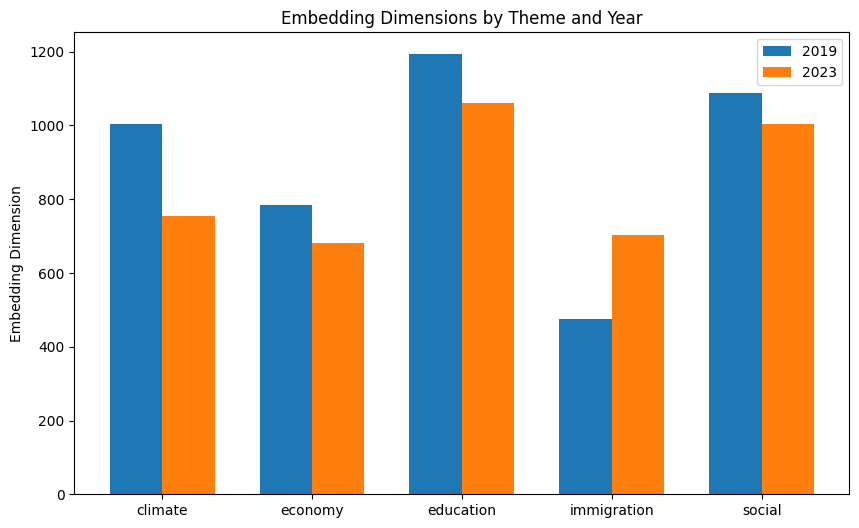

In [ ]:
labels = []
dim_2019 = []
dim_2023 = []
for theme in themes_keys:
    labels.append(theme)
    dim_2019.append(embedding_results[theme].get("19", {}).get("embedding_dimension", 0))
    dim_2023.append(embedding_results[theme].get("23", {}).get("embedding_dimension", 0))   
x = np.arange(len(labels)) 
width = 0.35         
fig, ax = plt.subplots(figsize=(10, 6))
bars1 = ax.bar(x - width/2, dim_2019, width, label='2019')
bars2 = ax.bar(x + width/2, dim_2023, width, label='2023')   

ax.set_xlabel('Themes')
ax.set_ylabel('Embedding Dimension')
ax.set_title('Embedding Dimensions by Theme and Year')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend()
